In [49]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy import signal       
from scipy.misc import derivative
import pyhrv     
from scipy.signal import find_peaks  
from scipy import interpolate   
import pyhrv.nonlinear as nl          
import neurokit2 as nk            
from scipy.stats import skew, kurtosis

%matplotlib inline

In [ ]:
# read your ECG signal
df = pd.read_csv(r'your path\ECG_signal.csv')
ecg_data=df['ECG'].to_numpy()
Fs = 250

In [11]:
f, ecg_welchperiodogram =  signal.welch(ecg_data, Fs, 'boxcar', nperseg=1024, detrend=False) 

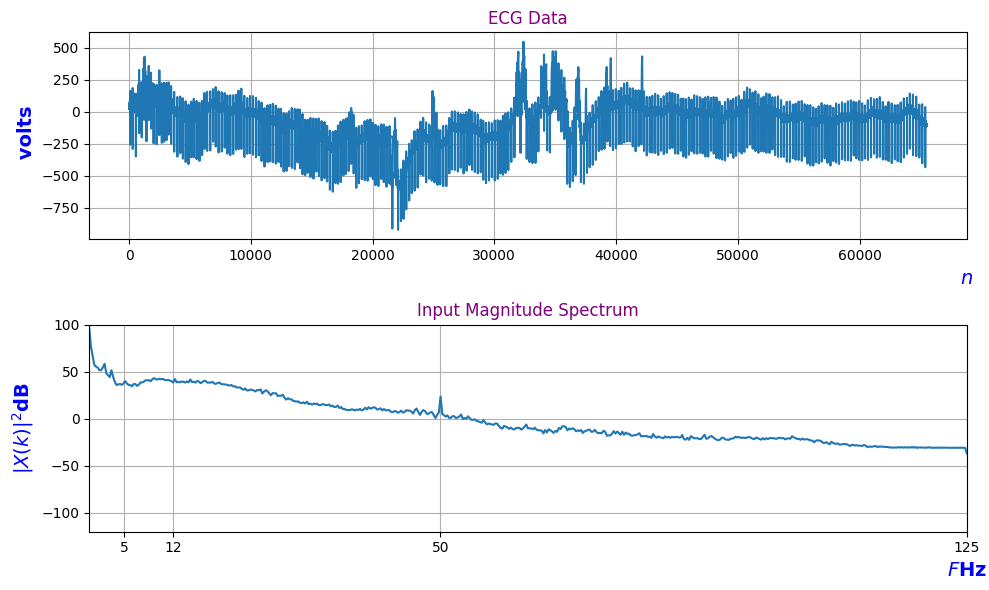

In [ ]:
plt.figure(figsize = (10,6)) 
plt.subplot(211)
plt.plot(ecg_data)
plt.title("ECG Data", color ="purple")
plt.ylabel(' volts', fontsize=14, color="blue", weight="bold")
plt.xlabel('$n$', fontsize=14, color="blue", weight="bold",  x=1.0)
plt.grid(True)
plt.subplot(212)
plt.plot(f, 20*np.log10(ecg_welchperiodogram))
plt.title("Input Magnitude Spectrum", color ="purple")
plt.ylabel('$|X(k)|^2$dB', fontsize=14, color="blue", weight="bold")
plt.xlabel('$F$Hz', fontsize=14, color="blue", weight="bold",  x=1.0)
plt.xticks([5,12,50,125])
plt.axis([0,125,-120,100])
plt.grid(True)
plt.tight_layout() # ensure sufficient spacing between subplots


# High Pass Filter Design

In [ ]:
Fc = 5  # Cutoff Frequency 
deltaF = 1 # Transition Bandwidth 
M = int(np.ceil(5.5 * Fs/deltaF)) # Filter Length  
MidM = int((M-1)/2) #Filter Midpoint

In [14]:
ncoeffHP = signal.firwin(M, Fc, window = 'hann', fs = Fs, pass_zero=False) 
w, HWHP = signal.freqz(ncoeffHP, fs = Fs)

 Plotting Impulse  & Frequency Response

C:\Users\krezaei\AppData\Local\Temp\ipykernel_14548\1928601848.py:3: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(ncoeffHP, linefmt='blue', markerfmt='ro', use_line_collection = True, basefmt=" ")


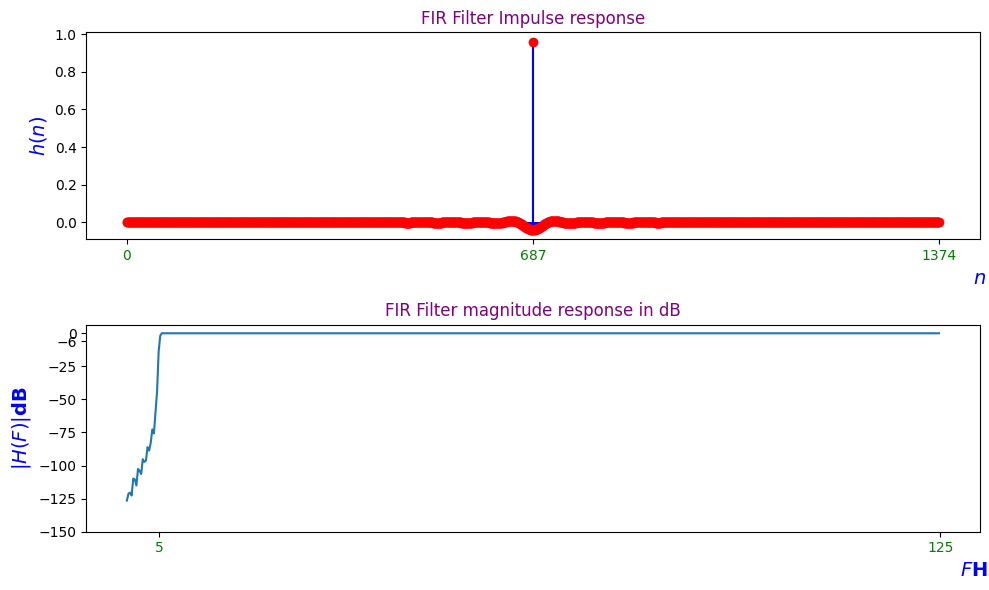

In [15]:
plt.figure(figsize = (10,6)) # 10 in by 6 in
plt.subplot(211)
plt.stem(ncoeffHP, linefmt='blue', markerfmt='ro', use_line_collection = True, basefmt=" ")
plt.title("FIR Filter Impulse response", color ="purple")
plt.ylabel('$h(n)$', fontsize=14, color="blue", weight="bold") # Could use rotation=0
plt.xlabel('$n$', fontsize=14, color="blue",  x=1.0)
plt.xticks([0,MidM,M-1], color="green")
plt.subplot(212)
plt.plot(w,20*np.log10(np.abs(HWHP)))
plt.title("FIR Filter magnitude response in dB", color ="purple")
plt.ylabel('$|H(F)|$dB', fontsize=14, color="blue", weight="bold") 
plt.xlabel('$F$Hz', fontsize=14, color="blue", weight="bold",  x=1.0)
plt.yticks([-150,-125,-100,-75,-50,-25,-6,0])
plt.xticks([5,125], color="green")
plt.tight_layout() # ensure sufficient spacing between subplots

In [16]:
ecg_HPoutput = signal.lfilter(ncoeffHP, [1.0], ecg_data)
f, ecg_HPoutputwelch =  signal.welch(ecg_HPoutput, Fs, 'boxcar', nperseg=1024, detrend=False) 

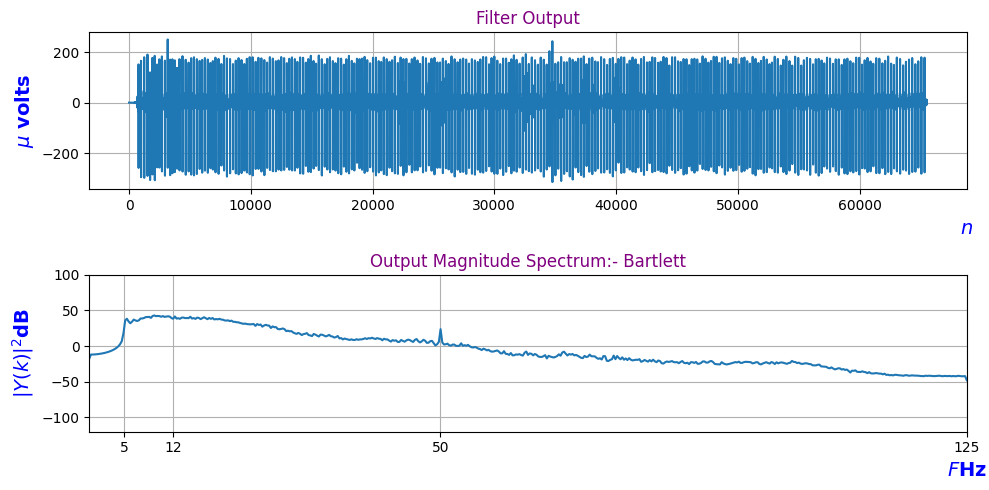

In [17]:
plt.figure(figsize = (10,5)) # 10 in by 6 in
plt.subplot(211)
plt.plot(ecg_HPoutput)
plt.title("Filter Output", color ="purple")
plt.ylabel('$\mu$ volts', fontsize=14, color="blue", weight="bold")
plt.xlabel('$n$', fontsize=14, color="blue", weight="bold",  x=1.0)
plt.grid(True)
plt.subplot(212)
plt.plot(f, 20*np.log10(ecg_HPoutputwelch))
plt.title("Output Magnitude Spectrum:- Bartlett", color ="purple")
plt.ylabel('$|Y(k)|^2$dB', fontsize=14, color="blue", weight="bold")
plt.xlabel('$F$Hz', fontsize=14, color="blue", weight="bold",  x=1.0)
plt.xticks([5,12,50,125])
plt.axis([0,125,-120,100])
plt.grid(True)
plt.tight_layout() # ensure sufficient spacing between subplots


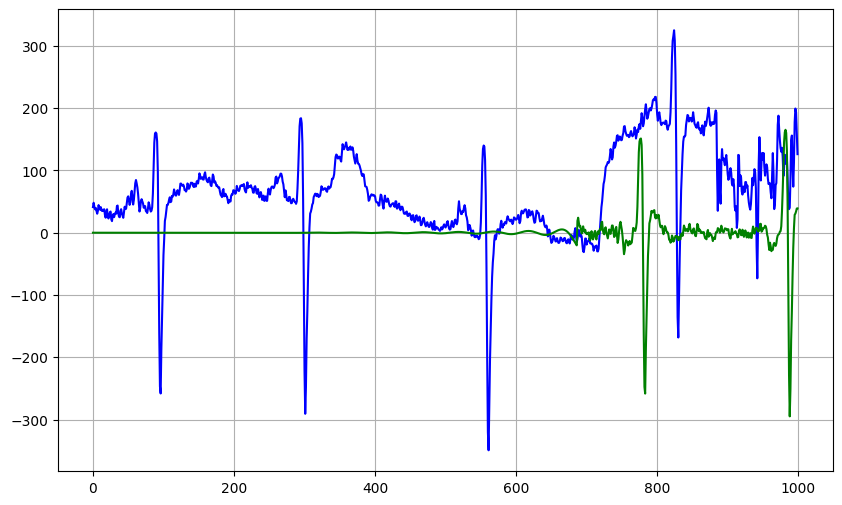

In [18]:
plt.figure(figsize = (10,6)) # 10 in by 6 in
plt.plot(ecg_data[0:1000], 'blue') # Original ECH
plt.plot(ecg_HPoutput[0:1000],'green') # Output of High Pass Filter
plt.grid(True)

In [19]:
ecg_HPoutputLR = ecg_HPoutput[MidM:len(ecg_HPoutput)] # Remove the first (M-1)/2 data points to remove the latency

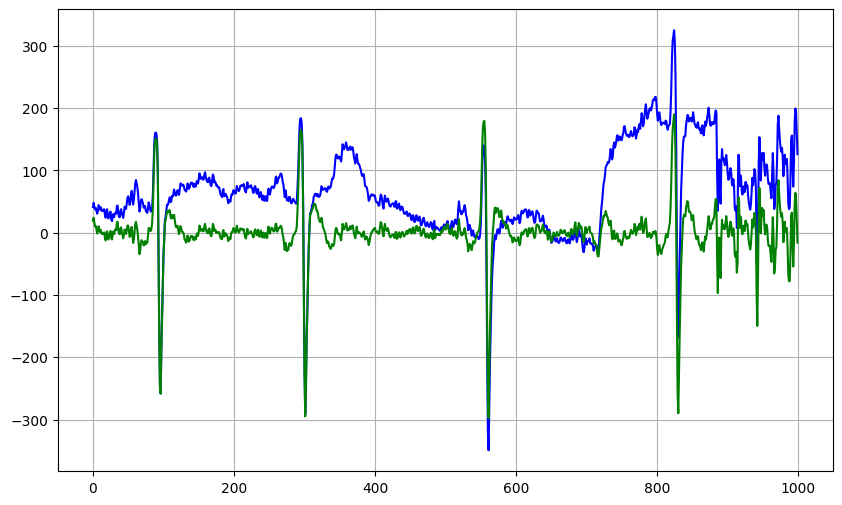

In [20]:
plt.figure(figsize = (10,6)) # 10 in by 6 in
plt.plot(ecg_data[0:1000], 'blue') # Original ECG
plt.plot(ecg_HPoutputLR[0:1000],'green') # Output of High Pass filter with Latency corrected. 
plt.grid(True)

# Lowpass Filter Design

In [ ]:
deltaLPF = 6 # Transition Bandwidth 
LPPassbandF = 12  # Passband Edge Frequency 
FcLP = LPPassbandF + deltaLPF/2   # Cutoff Frequency 
MLP = int(np.ceil(5.5 * Fs/deltaLPF))  # Filter Length 
MLP = 231 # select M to be odd for Integer Group Delay
MidMLP = int((MLP-1)/2) # Filter Midpoint

C:\Users\krezaei\AppData\Local\Temp\ipykernel_14548\423239826.py:5: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(ncoeffLP, linefmt='blue', markerfmt='ro', use_line_collection = True, basefmt=" ")


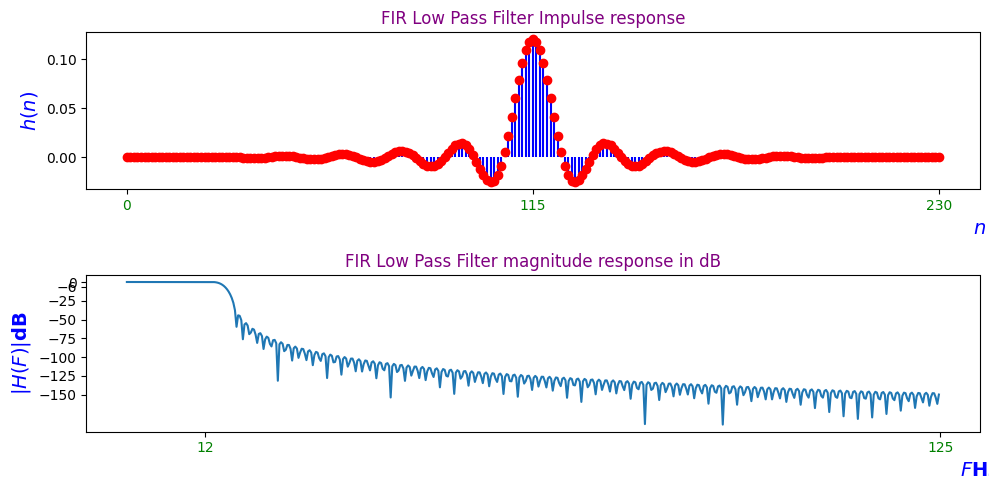

In [24]:
ncoeffLP = signal.firwin(MLP, FcLP, window = 'hann', fs = Fs, pass_zero=True) 
w, HWLP = signal.freqz(ncoeffLP, fs = Fs)
plt.figure(figsize = (10,5)) # 10 in by 5 in
plt.subplot(211)
plt.stem(ncoeffLP, linefmt='blue', markerfmt='ro', use_line_collection = True, basefmt=" ")
plt.title("FIR Low Pass Filter Impulse response", color ="purple")
plt.ylabel('$h(n)$', fontsize=14, color="blue", weight="bold") # Could use rotation=0
plt.xlabel('$n$', fontsize=14, color="blue",  x=1.0)
plt.xticks([0,MidMLP,MLP-1], color="green")
#plt.yticks([-0.01,0.048,0.05])
#plt.axis([0,M-1,-0.015,0.05])
plt.subplot(212)
plt.plot(w,20*np.log10(np.abs(HWLP)))
plt.title("FIR Low Pass Filter magnitude response in dB", color ="purple")
plt.ylabel('$|H(F)|$dB', fontsize=14, color="blue", weight="bold") 
plt.xlabel('$F$Hz', fontsize=14, color="blue", weight="bold",  x=1.0)
plt.yticks([-150,-125,-100,-75,-50,-25,-6,0])
plt.xticks([12,125], color="green")
plt.tight_layout() # ensure sufficient spacing between subplots

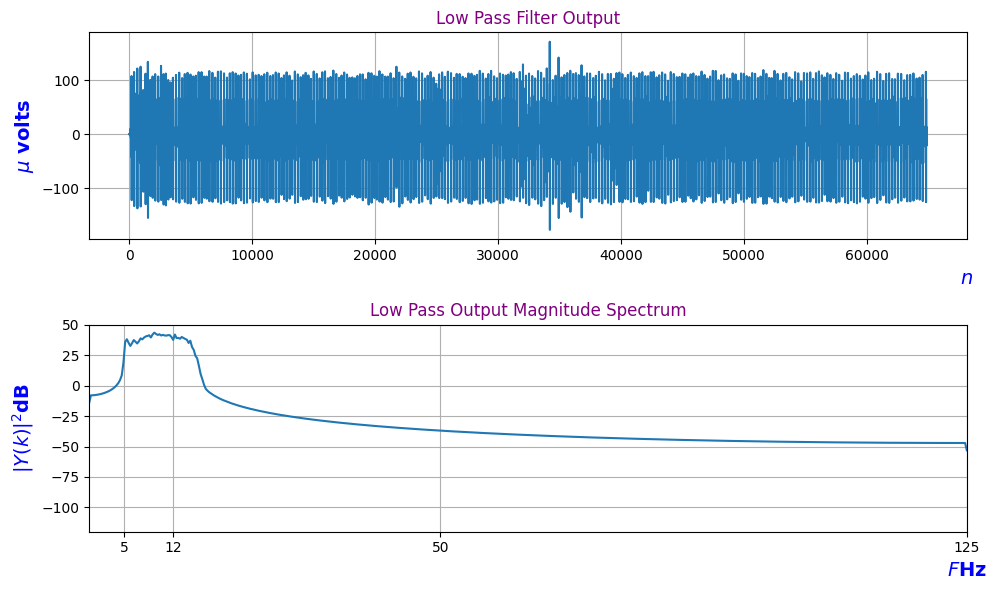

In [25]:
ecg_LPoutput = signal.lfilter(ncoeffLP, [1.0], ecg_HPoutputLR)
f, ecg_LPoutputwelch =  signal.welch(ecg_LPoutput, Fs, 'boxcar', nperseg=1024, detrend=False) 
plt.figure(figsize = (10,6)) # 10 in by 6 in
plt.subplot(211)
plt.plot(ecg_LPoutput)
plt.title("Low Pass Filter Output", color ="purple")
plt.ylabel('$\mu$ volts', fontsize=14, color="blue", weight="bold")
plt.xlabel('$n$', fontsize=14, color="blue", weight="bold",  x=1.0)
plt.grid(True)
plt.subplot(212)
plt.plot(f, 20*np.log10(ecg_LPoutputwelch))
plt.title("Low Pass Output Magnitude Spectrum", color ="purple")
plt.ylabel('$|Y(k)|^2$dB', fontsize=14, color="blue", weight="bold")
plt.xlabel('$F$Hz', fontsize=14, color="blue", weight="bold",  x=1.0)
plt.xticks([5,12,50,125])
plt.axis([0, 125,-120,50])
plt.grid(True)
plt.tight_layout() # ensure sufficient spacing between subplots


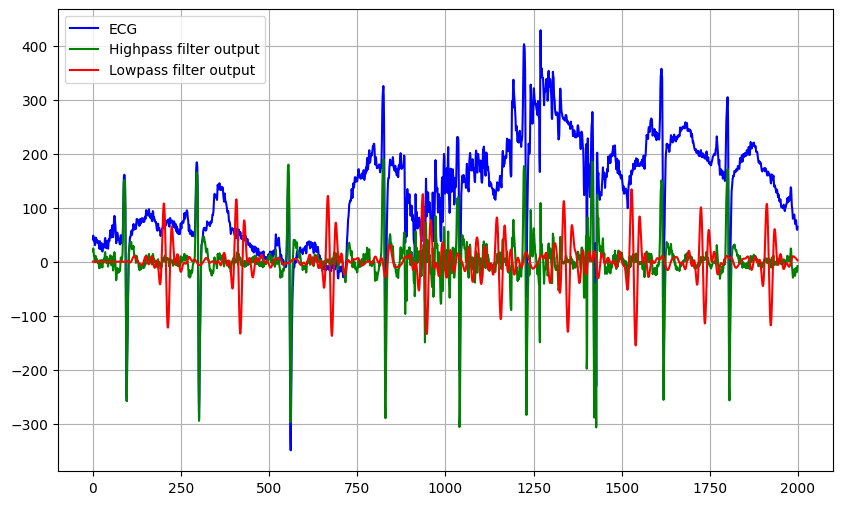

In [26]:
plt.figure(figsize = (10,6))
plt.plot(ecg_data[0:2000],'blue',label='ECG') # Original ECG
plt.plot(ecg_HPoutputLR[0:2000], 'green',label='Highpass filter output') #Output of High Pass FIlter
plt.plot(ecg_LPoutput[0:2000], 'red',label='Lowpass filter output') # Output of Low Pass Filter#
plt.legend(loc="upper left")
plt.grid(True)


In [27]:
ecg_LPoutputLR = ecg_LPoutput[MidMLP:len(ecg_LPoutput)] # Remove the first (M-1)/2 data points to remove the latency

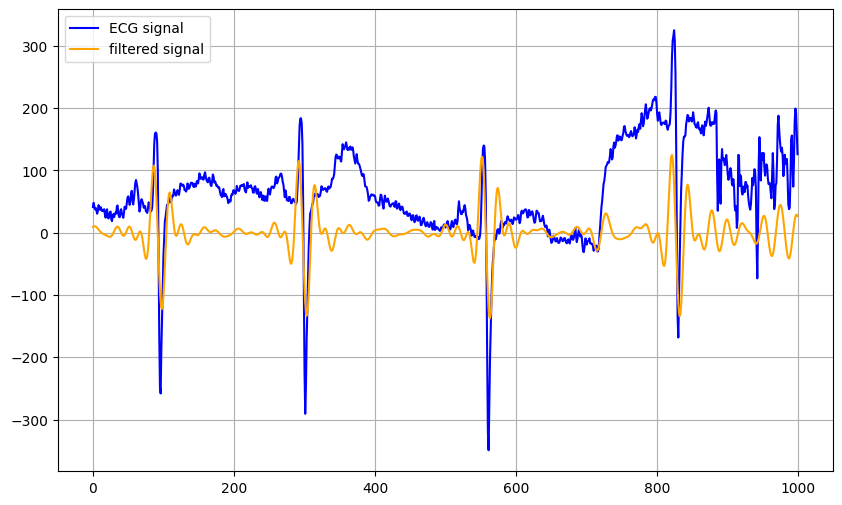

In [28]:
plt.figure(figsize = (10,6))
plt.plot(ecg_data[0:1000], 'blue',label='ECG signal') # Original ECG
plt.plot(ecg_LPoutputLR[0:1000], 'orange',label='filtered signal') # Output of Low Pass filter with Latency for both filters taken into account
plt.legend(loc="upper left")
plt.grid(True)

# Derivative

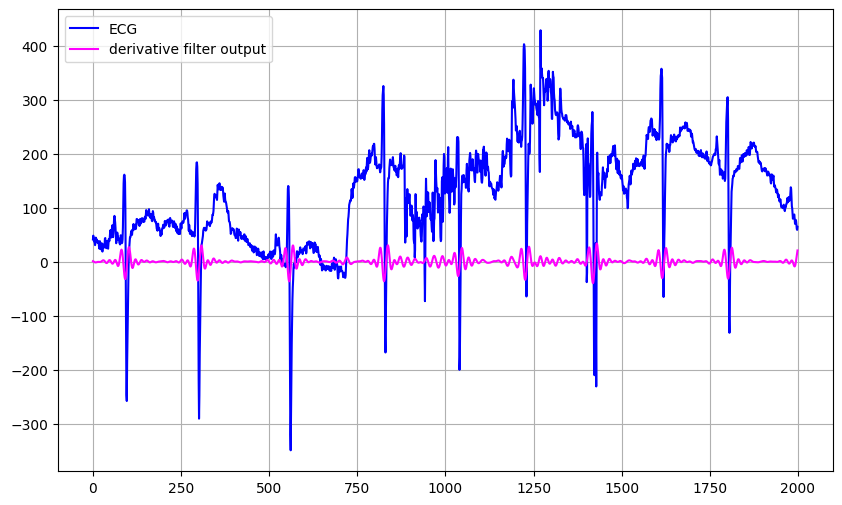

In [29]:
#get derivative from ECG signal  (using np library)
ecg_derivative=np.diff(ecg_LPoutputLR)           
plt.figure(figsize = (10,6))
plt.plot(ecg_data[0:2000],'blue',label='ECG') # Orginal ECG
plt.plot(ecg_derivative[0:2000], 'magenta',label='derivative filter output') # Output of Derivative
plt.legend(loc="upper left")
plt.grid(True)

# Squared signal

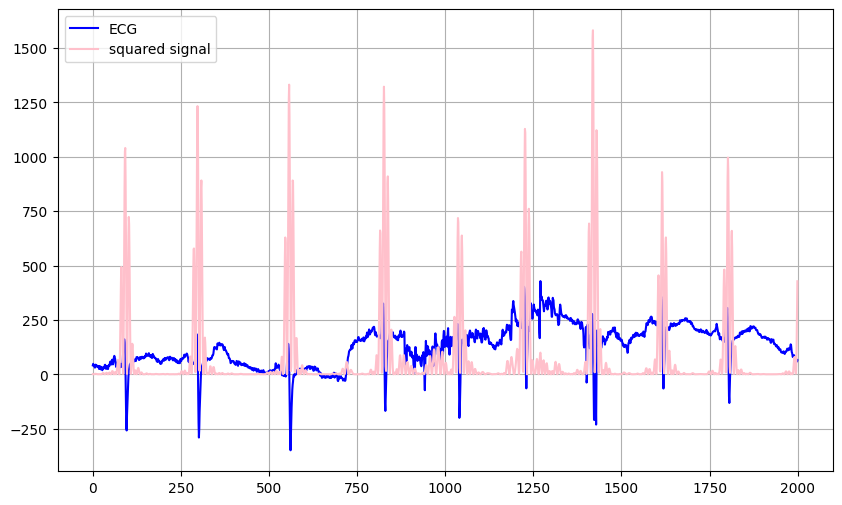

In [30]:
#signal is squared to enhance the dominant peaks (QRSs) and reduce the possibility of erroneously recognizing a T wave as an R peak
ecg_squared=ecg_derivative**2
plt.figure(figsize = (10,6))
plt.plot(ecg_data[0:2000],'blue',label='ECG') # Orginal ECG  
plt.plot(ecg_squared[0:2000], 'pink',label='squared signal') # Output of Squarer Aligned to take into account filter latencies
plt.legend(loc="upper left")
plt.grid(True)

# Applying moving average window

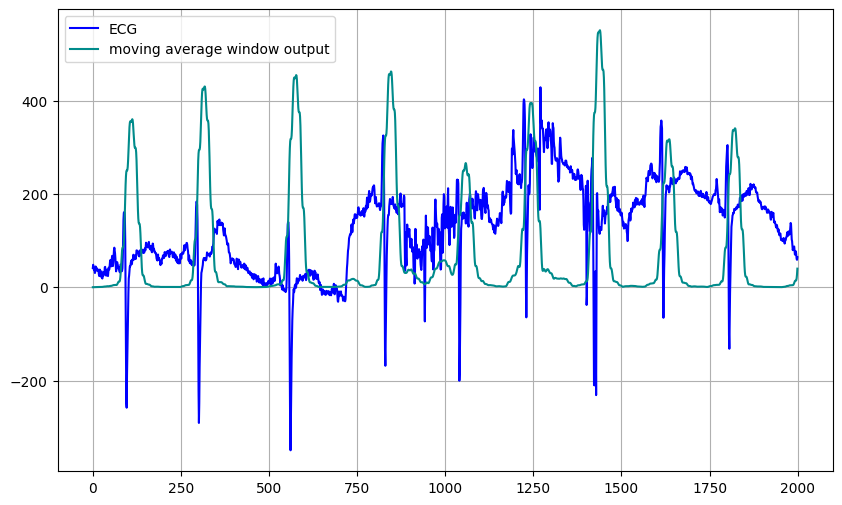

In [ ]:
#implementing moving average window
N=int(0.14*Fs) # determine the number of sample based on a window of 140ms = 0.14s
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'full') / w

ecg_movingaverage=moving_average(ecg_squared,N)          
plt.figure(figsize = (10,6))
plt.plot(ecg_data[0:2000],'blue',label='ECG') # Orginal ECG  
plt.plot(ecg_movingaverage[0:2000], 'darkcyan',label='moving average window output') 
plt.legend(loc="upper left")
plt.grid(True)

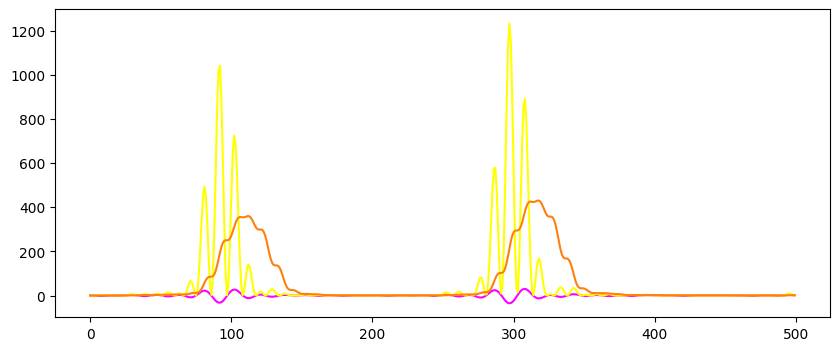

In [33]:
plt.figure(figsize = (10,4))
plt.plot(ecg_derivative[0:500], 'magenta') # Output of Derivative
plt.plot(ecg_squared[0:500], 'yellow') # Output of Squarer Aligned to take into account filter latencies
plt.plot(ecg_movingaverage[0:500], 'tab:orange') 

# Peak detection

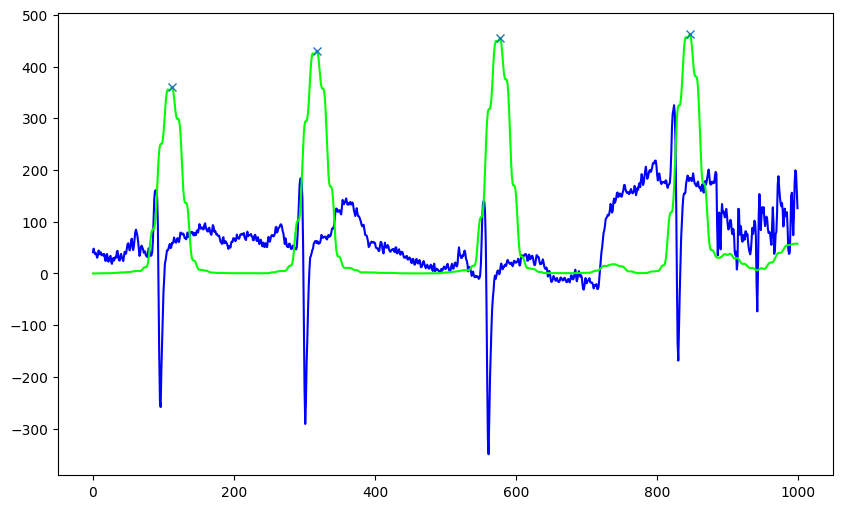

In [ ]:
#detecting signal peaks(preprocessed)
peaks = find_peaks(ecg_movingaverage, threshold=None ,height=200, distance=35)[0]
plt.figure(figsize = (10,6))
plt.plot(ecg_data[0:1000],'blue') # Orginal ECG  
plt.plot(ecg_movingaverage[0:1000], 'lime') 
plt.plot(peaks[0:4],ecg_movingaverage[peaks][0:4],"x")

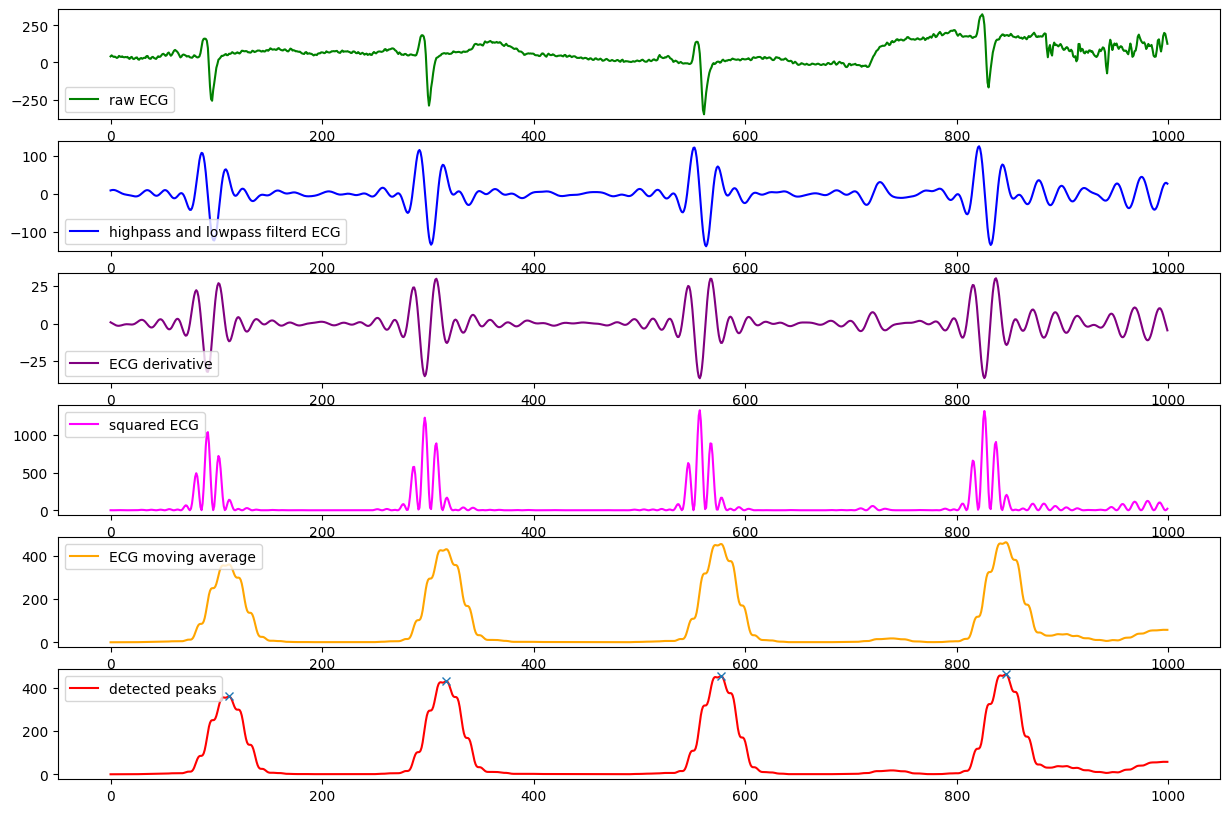

In [ ]:
# Whole process of peak detection
plt.figure(figsize = (15,10))
plt.subplot(6, 1, 1)
plt.plot(ecg_data[0:1000], 'green',label='raw ECG') 
plt.legend(loc="lower left")
plt.subplot(6, 1, 2)
plt.plot(ecg_LPoutputLR[0:1000], 'blue',label='highpass and lowpass filterd ECG') 
plt.legend(loc="lower left")
plt.subplot(6, 1, 3)
plt.plot(ecg_derivative[0:1000], 'purple', label='ECG derivative') 
plt.legend(loc="lower left")
plt.subplot(6, 1,4)
plt.plot(ecg_squared[0:1000], 'magenta', label='squared ECG') 
plt.legend(loc="upper left")
plt.subplot(6, 1, 5)
plt.plot(ecg_movingaverage[0:1000], 'orange', label='ECG moving average')
plt.legend(loc="upper left")
plt.subplot(6, 1, 6)
plt.plot(ecg_movingaverage[0:1000], 'red', label='detected peaks')
plt.plot(peaks[0:4],ecg_movingaverage[peaks][0:4],"x")
plt.legend(loc="upper left")

# rr-interval and Heart rate

In [ ]:
#calculating rr-intervals and heart rate
rr = np.diff(peaks)
HR = 60/(rr/Fs)

# Interpolation

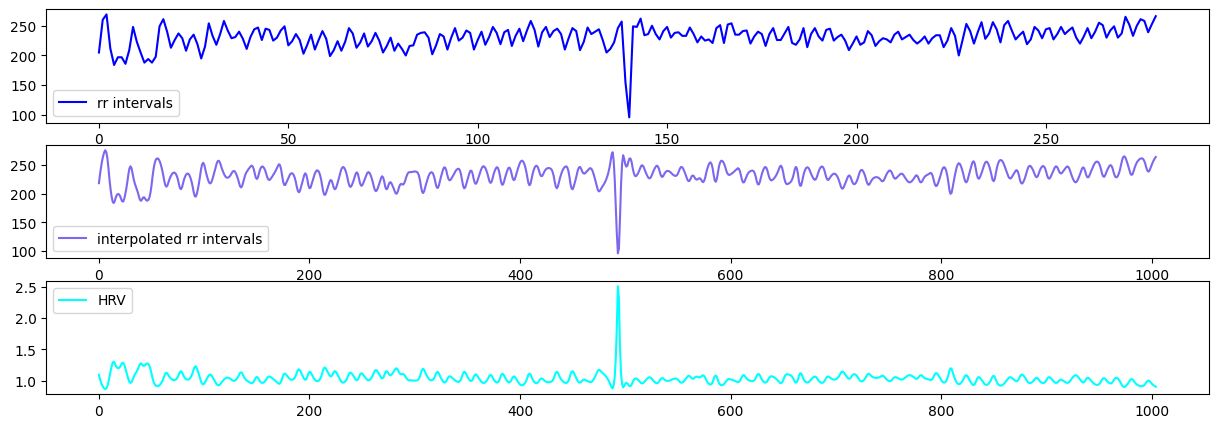

In [ ]:
#signal interpolation(quadratic)
x_2 = np.cumsum(rr)/ 256
f = interpolate.interp1d(x_2, rr, kind='quadratic',fill_value="extrapolate")

# sample rate for interpolation
fs = 4
steps = 1 / fs

# now we can sample from interpolation function
xx_2 = np.arange(1, np.max(x_2), steps)

rr_interpolated = f(xx_2)
HR_new=60/(rr_interpolated/fs)

plt.figure(figsize = (15,5))
plt.subplot(3, 1, 1)
plt.plot(rr, 'blue',label='rr intervals') 
plt.legend(loc="lower left")
plt.subplot(3, 1, 2)
plt.plot(rr_interpolated, 'mediumslateblue', label='interpolated rr intervals') 
plt.legend(loc="lower left")
plt.subplot(3, 1, 3)
plt.plot(HR_new, 'aqua', label='HRV') 
plt.legend(loc="upper left")


# Epoch setting

In [ ]:
NEpoch = 4*60                                        # fs=4 (after interpolation), each epoch is 60 seconds                                  
Noverlap = int(NEpoch/2)                                                  # Dinfine overlap of each epoch= 50%
numberofEpochs = (len(HR_new)-NEpoch)//(NEpoch-Noverlap) + 1       # get eact number of epochs
NEP=int(numberofEpochs) 
print('Number of Epochs:',numberofEpochs)

Number of Epochs: 7


# Feature extraction

In [51]:
def features(RR_interval, RR_interpolated):
    """features of time and frequency domain

    Args:
        RR_interval (array): rr intervals for extracting time features
        RR_interpolated (array): interpolated rr intervals for extracting frequency features

    Returns:
        pandas dataframe: a dataframe with all the features(columns) for a sample(row)
    """
      
    ## Time domain features
    # mean NN interval (muNN)
    muNN = np.mean(RR_interval)   
    # Standard deviation of a NNI series                       
    SDNN = pyhrv.time_domain.sdnn(RR_interval)
    # The root mean square of successive differences between normal heartbeats           
    RMSSD = pyhrv.time_domain.rmssd(RR_interval)   
    # The triangular index based on the NN interval histogram   
    TRindex = pyhrv.time_domain.triangular_index(nni=RR_interval, plot=False)  
    # Kurtosis
    kur = kurtosis(RR_interval) 
    # Skewness              
    skw = skew(RR_interval)                   
     # Approximate entropy(ApEn):amount of regularity and the unpredictability of fluctuations over time-series data 
    ApEn, parameters = nk.entropy_approximate(RR_interval)         
    
    # poincare(Lorenz) plot
    poincare_plot = nl.poincare(RR_interval,show=False, ellipse=False, vectors=False,legend=False)
    # Standard deviation along the minor axis
    SD1 = poincare_plot['sd1']  
    # Standard deviation along the major axis            
    SD2 = poincare_plot['sd2']  
    # Ratio between SD1 and SD2 (SD2/SD1)
    SDratio = poincare_plot['sd_ratio']     
    T  =  4 * SD1
    L = 4 * SD2
    # Cardiac sympathetic index
    CSI = L / T   
    # Modified cardiac sympathetic index               
    CSI_Modified = L ** 2 / T    
    # cardiac vagal index
    CVI = np.log10(L * T)        
    
    ## Frequency domain features(use interpolated rr for frequency features)
    fbands={'vlf': (0.01, 0.04), 'lf': (0.04, 0.2), 'hf': (0.2, 2)}
     # welch freq features
    welch_freq_features = pyhrv.frequency_domain.welch_psd(RR_interpolated,fbands, show=False, show_param=False, legend=False)       
    # Logarithmic power
    welch_log_powers=welch_freq_features['fft_log']   
    # LF/HF ratio      
    fftratio = welch_freq_features['fft_ratio']   
    # very low frequency power           
    welch_log_VLF = welch_log_powers[0] 
    # low frequency power
    welch_log_LF = welch_log_powers[1]  
    # high frequency power                     
    welch_log_HF = welch_log_powers[2]                       
    
    # Features dataframe 
    df_features_name = ['muNN', 'SDNN', 'RMSSD', 'TRindex', 'kurtosis', 'skewness', 'ApEn', 'LF/HF ratio', 'VLF power', 'LF  power', 'HF power', 'SD1','SD2', 'CSI_Modified', 'CVI', 'SD ratio']  
    df_features_value = np.column_stack((muNN, SDNN, RMSSD, TRindex, kur, skw, ApEn, fftratio, welch_log_VLF, welch_log_LF, welch_log_HF, SD1 , SD2, CSI_Modified, CVI, SDratio))    
    df_features = pd.DataFrame(data=df_features_value, columns=df_features_name )
    
    return df_features

,muNN,SDNN,RMSSD,TRindex,kurtosis,skewness,ApEn,LF/HF ratio,VLF power,LF power,HF power,SD1,SD2,CSI_Modified,CVI,SD ratio
0,230.582143,18.014143,20.333157,4.516129,11.024141,-1.929934,1.077845,0.212924,2.943072,3.257002,4.80382,14.376882,20.867621,121.154955,3.681258,1.451471


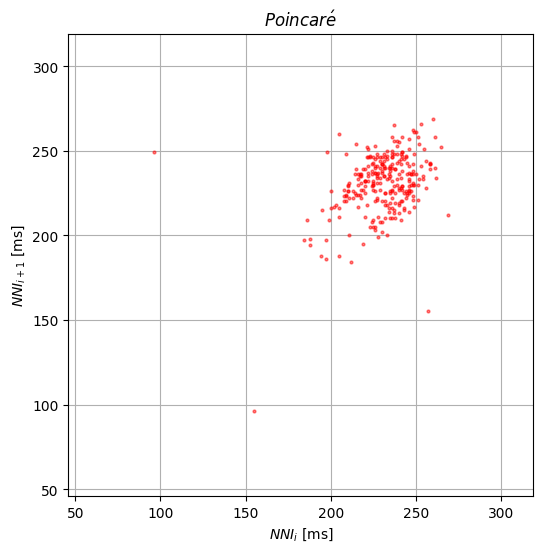

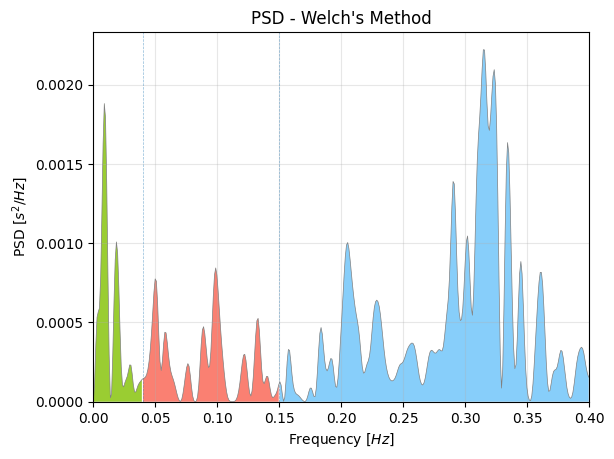

In [52]:
features(rr, rr_interpolated)